### Parallel Python

In [1]:
import numpy
import matplotlib.pyplot
import pandas
import glob
import emcee

import eztao
import eztao.ts

import celerite

import pp

In [2]:
################################
# Define CARMA function for DRW
################################

def get_carma_parameter(tau, amp):
    """Get DRW parameters in CARMA notation (alpha_*/beta_*).

    alpha_1 = -1 / tau
    sigma^2 = tau * sigma_kbs^2 / 2
    sigma_kbs = np.sqrt( 2 * sigma^2 / tau )
    beta_0 = sigma_kbs

    Returns:
        [alpha_1, beta_0].
    """
    return [-1.0 / tau, numpy.sqrt( 2.0 * amp**2.0 / tau)]

################################
# Define the prior and log-probability functions for MCMC
################################

# prior function for tau_perturb
def lnprior_perturb(theta):
    """Prior on perturbation timescale. Note: this is a wedge like prior."""

    # determine DHO timescales
    log10_tau_perturb = (theta[-1] - theta[-2])/numpy.log(10)
    if -3 <= log10_tau_perturb <= 5:
        prior = 0
    else:
        prior = -(numpy.abs(log10_tau_perturb - 1) - 4)

    return prior

def lnprior_bounds(theta):
    """Prior on AR and MA parameters. This is a flat prior."""

    # Place some bounds on the parameter space
    bounds_low = numpy.array([-15, -15, -20, -20])
    bounds_high = numpy.array([15, 15, 10, 10])

    log_a1, log_a2, log_b0, log_b1 = theta
    if ( 
        bounds_low[0] < log_a1 < bounds_high[0] 
        and bounds_low[1] < log_a2 < bounds_high[1] 
        and bounds_low[2] < log_b0 < bounds_high[2] 
        and bounds_low[3] < log_b1 < bounds_high[3] 
       ):
        return 0.0
    return -numpy.inf

# We'll use the eztao version which effectively returns "gp.log_likelihood" from the GP and np.inf otherwise
def lnlike(theta, y, gp):
    return -eztao.ts.neg_param_ll(theta, y, gp)

def lnprob(theta, y, gp):
    lp_bounds = lnprior_bounds(theta)
    lp_perturb = lnprior_perturb(theta)                              
    if not numpy.isfinite(lp_bounds):
        return -numpy.inf
    return lp_bounds + lp_perturb + lnlike(theta, y, gp)

################################
# Define other functions
################################

# chi-sqared
def chisqg(y_data, y_model, sd=None):
    chisq = numpy.nansum(((y_data-y_model)/sd)**2)
    return chisq

In [3]:
def getCARMAstats(file):
    ################################
    # setup
    ################################

    #file_name = file[5:-4]
    #file_name = file[5:-8]
    file_name = file[22:-8]
    
    # read-in light curve
    df = pandas.read_csv(file)

    # obtain values from df
    ra = df['ra'].values[0]
    dec = df['dec'].values[0]
    t = df['mjd'].values
    y_real = df['mag'].values
    yerr_real = df['magerr'].values
    lc_length = len(t)
    
    # invert the magnitudes
    y_real_inverted = (min(y_real)-y_real)

    # normalize to unit standard deviation and zero mean
    y = (y_real_inverted - numpy.mean(y_real_inverted))/numpy.std(y_real_inverted)
    yerr = yerr_real/numpy.std(y_real_inverted)
        
    
    ################################
    ################################
    #
    # DRW Process
    #
    ################################
    ################################
    
    # obtain best-fit
    bounds = [(0.01, 10.0), (0.01, 10.0)]
    best_drw = eztao.ts.drw_fit(t, y, yerr, user_bounds=bounds)
    
    # get best-fit in CARMA space
    best_drw_arma = numpy.exp(get_carma_parameter(best_drw[0], best_drw[1]))
    
    
    ################################
    ################################
    #
    # DHO Process
    #
    ################################
    ################################
    
    # obtain best-fit
    bounds = [(-15, 15), (-15, 15), (-20, 10), (-20, 10)]
    best_dho = eztao.ts.dho_fit(t, y, yerr, user_bounds=bounds)

    # Create the GP model -- instead of creating a "model" function that is then called by the "lnlike" function from tutorial,
    #  we will create a GP that will be passed as an argument to the MCMC sampler. This will be the "gp" that is passed to
    #  the "lnprob" and "param_ll" functions
    dho_kernel = eztao.carma.DHO_term(*numpy.log(best_dho))
    dho_gp = celerite.GP(dho_kernel, mean=numpy.median(y))
    dho_gp.compute(t, yerr)

    ################################
    # MCMC
    ################################

    # Initalize MCMC
    data = (t, y, yerr)
    nwalkers = 128
    niter = 2048

    initial = numpy.array(numpy.log(best_dho))
    ndim = len(initial)
    p0 = [numpy.array(initial) + 1e-7 * numpy.random.randn(ndim) for i in range(nwalkers)]

    # Create the MCMC sampler -- note that the GP is passed as an argument in addition to the data
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[y, dho_gp])

    # run a burn-in surrounding the best-fit parameters obtained above
    p0, lp, _ = sampler.run_mcmc(p0, 200)
    sampler.reset()

    # clear up the stored chain from burn-in, rerun the MCMC
    pos, prob, state = sampler.run_mcmc(p0, niter);

    ################################
    # Obtain the Best Fit: theta_max
    ################################

    # put all the samples that explored in MCMC into a single array
    samples = sampler.flatchain
    
    # find the parameters that have the best fit 
    theta_max_index = numpy.argmax(sampler.flatlnprobability)
    theta_max_probability = sampler.flatlnprobability[theta_max_index]
   
    theta_max  = samples[theta_max_index] # these are in log-space
    theta_max_norm = numpy.exp(theta_max) # take the exponent to get into 'normal' space
    
    
    ################################
    ################################
    #
    # Simulate and Return
    #
    ################################
    ################################
    
    ################################
    # Simulate and plot light curves
    ################################
    
    # create simulated light curve
    drw_sim_t, drw_sim_y, drw_sim_yerr = eztao.ts.carma_sim.pred_lc(t, y, yerr, best_drw_arma, 1, t)
    dho_sim_t, dho_sim_y, dho_sim_yerr = eztao.ts.carma_sim.pred_lc(t, y, yerr, theta_max_norm, 2, t)
    
    # directory to save plots to
    plot_dir = 'plots_and_figures/carma_plots'
    # plot drw
    plot = True  
    if plot:
        matplotlib.pyplot.figure()
        matplotlib.pyplot.errorbar(t, y, yerr=yerr, label='data',
                                   linestyle="None", marker='.', ms=3., color='purple', ecolor='0.8')
        matplotlib.pyplot.plot(drw_sim_t, drw_sim_y, label=f'drw {best_drw_arma}')
        matplotlib.pyplot.legend()
        matplotlib.pyplot.savefig(f'{plot_dir}/{file_name}_drw_fit.png')
        matplotlib.pyplot.close()

        # plot dho
        matplotlib.pyplot.figure()
        matplotlib.pyplot.errorbar(t, y, yerr=yerr, label='data',
                                   linestyle="None", marker='.', ms=3., color='purple', ecolor='0.8')
        matplotlib.pyplot.plot(dho_sim_t, dho_sim_y, label=f'dho {theta_max_norm}')
        matplotlib.pyplot.legend()
        matplotlib.pyplot.savefig(f'{plot_dir}/{file_name}_dho_fit.png')
        matplotlib.pyplot.close()
    
    ################################
    # Determine best fit
    ################################
    
    # get chi-squared from sim light curves
    chisq_drw = chisqg(y, drw_sim_y, yerr)
    chisq_dho = chisqg(y, dho_sim_y, yerr)
    
    # determine best fit
    best_fit = 'DRW'
    if chisq_drw > chisq_dho and not numpy.isinf(chisq_dho):
        best_fit = 'DHO'
    
    ################################
    # Return
    ################################
    
    return file_name, ra, dec, t, y_real, yerr_real, best_drw, best_drw_arma, chisq_drw, best_dho, theta_max_norm, theta_max_probability, chisq_dho, best_fit, lc_length

In [ ]:
ppservers = ()

# creates jobserver with ncpus workers
ncpus = 24
job_server = pp.Server(ncpus, ppservers=ppservers)

print("Starting pp with", job_server.get_ncpus(), "workers")

# get list of data files
#repository = glob.glob('data/*.csv')
repository = glob.glob('../../AGN_LightCurves/*.parquet')

# intialize lists to save to
file_names = []
times = []
magnitudes = []
mag_errors = []
ras = []
decs =[]
best_fit_drws = []
best_fit_drws_arma = []
best_fit_dhos = []
best_mcmc_dhos = []
dho_probabilities = []
chi_squared_drw = []
chi_squared_dho = []
best_fits = []
lc_lengths = []

# Submit a list of jobs running getCARMAstats for each file in repository
# getCARMAstats - the function
# (file,) - file with AGN lc
# (chisqg, ...) - tuple with functions on which getCARMAstats depends
# ("numpy", ...) - tuple with package dependencies to be imported
jobs = [(file, job_server.submit(getCARMAstats ,(file,), 
                                 (get_carma_parameter, lnprior_perturb, lnprior_bounds, lnlike, lnprob, chisqg,), 
                                 ("numpy", "matplotlib.pyplot", "pandas", "emcee", "eztao", "eztao.ts",
                                  "celerite"))) for file in repository]

job_num = 1
for file, job in jobs:
    # start job
    file_name, ra, dec, t, y, yerr, best_drw, best_drw_arma, chisq_drw, best_dho, best_mcmc_dho, dho_probability, chisq_dho, best_fit, lc_length = job()
        
    # save data from job
    file_names.append(file_name)
    ras.append(ra)
    decs.append(dec)
    times.append(t)
    magnitudes.append(y)
    mag_errors.append(yerr)
    best_fit_drws.append(best_drw)
    best_fit_drws_arma.append(best_drw_arma)
    chi_squared_drw.append(chisq_drw)
    best_fit_dhos.append(best_dho)
    best_mcmc_dhos.append(best_mcmc_dho)
    dho_probabilities.append(dho_probability)
    chi_squared_dho.append(chisq_dho)
    best_fits.append(best_fit)
    lc_lengths.append(lc_length)
    
    #print(f'Completed [{job_num}/{len(jobs)}]: {file_name}')
    job_num += 1

job_server.print_stats()

In [5]:
agn_fit_data = pandas.DataFrame({'Filenames': file_names, 'RA': ras, 'DEC': decs, 'Times (MJD)': times, 
                                 'Magnitudes': magnitudes, 'Mag Errors': mag_errors, 
                                 'Best DRW Fit': best_fit_drws, 'Best DRW ARMA Fit': best_fit_drws_arma, 'DRW chisq': chi_squared_drw,
                                 'Best DHO Fit': best_fit_dhos, 'DHO MCMC Fit': best_mcmc_dhos, 'DHO MCMC Probability': dho_probabilities, 'DHO chisq': chi_squared_dho,
                                 'Best Fit': best_fits, 'LC Length': lc_lengths})

# save dataframe
agn_fit_data.to_csv('agn_fit_data.csv')
agn_fit_data

,Filenames,RA,DEC,Times (MJD),Magnitudes,Mag Errors,Best DRW Fit,Best DRW ARMA Fit,DRW_chi_sq,Best DHO Fit,DHO MCMC Fit,DHO MCMC Probability,DHO_chi_sq,Best Fit,LC Length
0,0.2032_-7.1532_ztfg,0.203240,-7.153253,"[58283.4428935, 58286.4428704, 58295.4461921, ...","[17.516969699999997, 17.4566288, 17.5868243999...","[0.0247562788, 0.0239279121, 0.0257828757, 0.0...","[1.010050167084168, 1.3983599295811213]","[0.3715581744238082, 7.154319915182115]",1.523894e+01,"[0.7563143342590858, 3831.8932677067523, 1.066...","[0.7426933024198086, 4668.4432092163015, 31.44...",-241.710495,42.751265,DRW,183
1,0.8643_27.6548_ztfg,0.864381,27.654870,"[58263.4847338, 58271.4756597, 58274.4529861, ...","[18.0273285, 17.6561546, 17.992786399999996, 1...","[0.0269577354, 0.0219427999, 0.0264183898, 0.0...","[1.2333921359960753, 1.010050167084168]","[0.444514699448269, 3.6189958352817695]",2.831278e+02,"[1427.379826025981, 848.887373424316, 977.5525...","[1086.6456230768797, 72.65098701263109, 174.48...",-537.938983,6.346649,DHO,390
2,1.0082_70.3217_ztfg,1.008609,70.321808,"[58252.467963, 58252.4684838, 58255.4317361, 5...","[20.3061562, 20.148098, 19.9521751, 20.8079872...","[0.129920244, 0.141349345, 0.124755882, 0.1965...","[1.0500751475512389, 2.7588869214843994]","[0.385847603826428, 45.03722844030981]",1.977041e+00,"[2.2824317638278018, 0.01944239091497917, 0.22...","[2.301410580188402, 0.01959729645725201, 0.231...",-417.570321,113.416616,DRW,306
3,1.5813_20.2029_ztfg,1.581381,20.202983,"[58268.4661921, 58277.4619213, 58280.447419, 5...","[14.7221251, 14.7285233, 14.7703943, 14.734273...","[0.0106572807, 0.0106579475, 0.0106633035, 0.0...","[1.1950749694448974, 53.875071338834985]","[0.43310824737591036, 1.8552775792865804e+30]",2.396875e-23,"[17.999252892955468, 0.18198048560711882, 3.18...","[18.479621411100563, 0.18848458434894308, 3.27...",-105.611053,117.937169,DRW,366
4,10.72_-23.541_ztfg,10.720075,-23.540989,"[58330.4594676, 58333.4387037, 58336.4817477, ...","[15.3464823, 15.387213699999998, 15.394475, 15...","[0.0196861867, 0.0197297633, 0.0197379421, 0.0...","[1.1488679596818578, 2.2404715517338794]","[0.4187747697475258, 19.222889126996062]",3.464013e-01,"[5.365725909098569, 0.12296431697008198, 0.995...","[5.198760304432352, 0.11897660824523043, 0.967...",-171.118436,16.429343,DRW,133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,90.5437_28.4721_ztfg,90.543631,28.472096,"[58204.1298495, 58204.17239580001, 58205.12875...","[15.1023655, 15.1037445, 15.0927429, 15.091063...","[0.0117217041999999, 0.0117235724, 0.011708719...","[1.010050167084168, 599.9128731740166]","[0.3715581744238082, inf]",0.000000e+00,"[0.2395730473553611, 0.0007544748959554177, 0....","[0.2395730424059954, 0.0007544748540621571, 0....",-inf,149.850980,DRW,225
383,90.6581_65.3712_ztfg,90.657663,65.371379,"[58204.19048609999, 58207.247662, 58207.256643...","[15.5720406, 15.8300734, 15.726823800000002, 1...","[0.013086074, 0.0136499358, 0.0134064704, 0.01...","[3.404449112362303, 1.010050167084168]","[0.7454752990570682, 2.1687842518540457]",6.820689e+02,"[429.6482362182843, 26445.99798671544, 0.00112...","[508.33735451089615, 7.3348120090523246, 30.06...",-401.592880,4.578379,DHO,298
384,91.454_-27.9112_ztfg,91.454290,-27.910989,"[58205.1373843, 58386.5221412, 58423.4174653, ...","[17.092571300000003, 17.559841199999997, 17.23...","[0.0260783136, 0.0326710902, 0.0278091952, 0.0...","[1.0573039547608658, 63.68998289004165]","[0.38836804648746215, 1.1031338656327183e+38]",5.175223e-25,"[9.24735403465315, 0.03617685501620473, 0.7985...","[7.6909138124182705, 0.029641547829462055, 0.6...",-29.748831,15.578836,DRW,92
385,93.9015_71.0375_ztfg,93.901677,71.037576,"[58204.1684606, 58204.1900116, 58207.2527199, ...","[14.4023151, 14.4292612, 14.5862532, 14.610807...","[0.0121623082, 0.0121789305, 0.0122852838, 0.0...","[1.0527375632617397, 1.010050167084168]","[0.38677801360438024, 4.023644121864515]",1.404143e+02,"[155.80224620085792, 3.181002532648

### Combine Dataframes

In [1]:
import numpy as np
import pandas as pd

In [2]:
# read data frame
agn_fit_data = pd.read_csv("agn_fit_data.csv")

# read in properties data frame
agn_properties = pd.read_csv("BAT_AGN_BASS_Data.csv")

In [3]:
def round_colemn(df, key, decimals=3):
    df[key] = np.around(df[key].tolist(), decimals=decimals)
    
    # note: return statement is redundant since Python is pass-by-reference
    # but return is generally good practice
    return df

In [4]:
decimal_places = 1

# round fit RA and DEC
agn_fit_data = round_colemn(agn_fit_data, 'RA', decimal_places)
agn_fit_data = round_colemn(agn_fit_data, 'DEC', decimal_places)

# round properties RA and DEC
agn_properties = round_colemn(agn_properties, 'RA', decimal_places)
agn_properties = round_colemn(agn_properties, 'DEC', decimal_places)

In [6]:
# merge dataframes
agn_dataframe = pd.merge(agn_fit_data, agn_properties, how='left', on=['RA', 'DEC'], validate='one_to_one')

# removed unamed colemns
agn_dataframe = agn_dataframe.loc[:, ~agn_dataframe.columns.str.contains('^Unnamed')]

# save dataframe
agn_dataframe.to_csv('agn_dataframe.csv')

### Timescales

In [ ]:
def dho_timescales(params):
    """Compute a couple DHO timescales from CARMA parameters (in normal space).

    - damping factor
    - decay timescale
    - rise/damped QPO timescale
    - perturbation timescale
    - decorrelation timescale
    - natural oscillation frequency
    """
   
    # expand params
    a1, a2, b0, b1 = params  

    # damping factor & natural frequency
    xi = a1/(2*np.sqrt(a2))
    omega_0 = np.sqrt(a2)   

    # placeholder for two timescales
    tau_perturb = b1/b0
    tau_decay = 0
    tau_rise_dqpo = 0
    tau_decorr = 0

    roots = np.roots([1, a1, a2])
    if xi < 1:
        tau_decay = np.abs(1/roots[0].real)
        tau_rise_dqpo = 2*np.pi*np.abs(1/roots[0].imag)/np.sqrt(1 - xi**2)
        tau_decorr = (np.pi/2)*np.pi*2/omega_0
    else:
        tau_decay = np.abs(1/np.max(roots.real))
        tau_rise_dqpo = np.abs(1/np.min(roots.real))
        tau_decorr = (tau_decay + tau_rise_dqpo)*np.pi/2
 
    return np.array([xi, tau_decay, tau_rise_dqpo, tau_perturb, tau_decorr, omega_0])

### Bad Fits
Exclude fits for DRW if chi-sq = 0 and DHO if chi-sq = inf 

In [1]:
import numpy as np
import pandas as pd

In [2]:
agn_dataframe = pd.read_csv("agn_dataframe.csv")

In [3]:
# modify datarame to account for bad fits
# if best chi-sq has a bad fit, then check the other chi-sq
# if both fits are bad, then assign chi-sq to 'None'

adjusted_best_fits = []

for index, row in agn_dataframe.iterrows():
    best_fit = row['Best Fit']
    drw_chisq = row['DRW_chi_sq']
    dho_chisq = row['DHO_chi_sq']
    
    # if Best Fit is DRW and is bad...
    if best_fit == 'DRW' and drw_chisq == 0:
        if not np.isinf(dho_chisq):
            adjusted_best_fits.append('DHO')
        else:
            adjusted_best_fits.append('None')
            
    # if Best Fit is DHO and is bad...
    elif best_fit == 'DRW' and np.isinf(dho_chisq):
        if not drw_chisq == 0:
            adjusted_best_fits.append('DRW')
        else:
            adjusted_best_fits.append('None')
    
    # if Best Fit is good, then save it
    else:
        adjusted_best_fits.append(best_fit)
        
# replace adjusted values
#agn_dataframe['Best Fit'] = agn_dataframe['Best Fit'].replace(adjusted_best_fits)
agn_dataframe['Best Fit'] = adjusted_best_fits

# removed unamed colemns
agn_dataframe = agn_dataframe.loc[:, ~agn_dataframe.columns.str.contains('^Unnamed')]

# save dataframe
agn_dataframe.to_csv('adjusted_agn_dataframe.csv')

### Calculate SNR

In [1]:
import numpy as np
import pandas as pd

In [2]:
agn_dataframe = pd.read_csv("adjusted_agn_dataframe.csv")

In [7]:
# calculate snr for each row in the data frame
snr = []

# index each AGN in agn_fit_data and calculate SNR
for index, row in agn_dataframe.iterrows():
    # get data from row
    y = row['Magnitudes']
    err = row['Mag Errors']
    
    # convert into float lists
    y = convert_to_float_list(y)
    err = convert_to_float_list(err)
    
    # mean of mag and err
    if y != flag:
        mean_y = np.mean(y)
        mean_err = np.mean(err)
        snr_row = mean_y / mean_err
    else:
        snr_row = np.NAN
    
    # save data
    snr.append(snr_row)

# add snr
agn_dataframe['SNR'] = snr

# save to new .csv file
agn_dataframe.to_csv('adjusted_agn_dataframe.csv')

### Relationships

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
agn_dataframe = pd.read_csv("adjusted_agn_dataframe.csv")

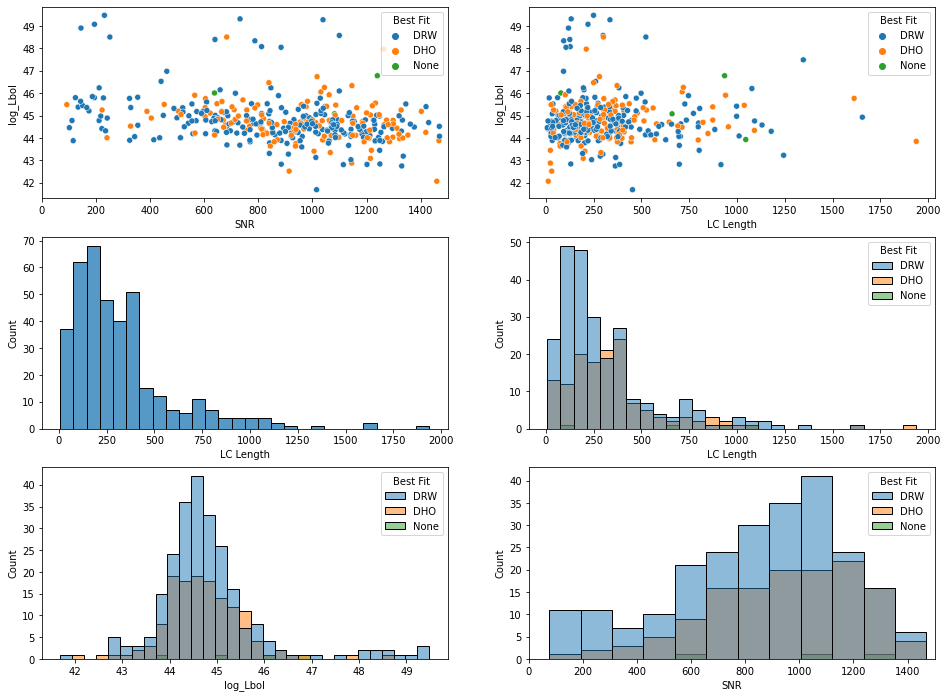

In [8]:
fig, axs = plt.subplots(3, 2, figsize=(16, 12))

#######
# row 0
#######
row = 0

# SNR vs LBol
sns.scatterplot(data=agn_dataframe, x='SNR', y ='log_Lbol', hue='Best Fit', ax=axs[row,0])
axs[row, 0].set_xlim(0, 1500) 
# note: there are some outliers

# LC Length vs LBol
sns.scatterplot(data=agn_dataframe, x='LC Length', y ='log_Lbol', hue='Best Fit', ax=axs[row,1])

#######
# row 1
#######
row += 1

# histogram of LC Length
sns.histplot(data=agn_dataframe, x='LC Length', ax=axs[row,0])

# histogram of LC Length for best fit
sns.histplot(data=agn_dataframe, x='LC Length', hue='Best Fit', ax=axs[row,1])

#######
# row 2
#######
row += 1

# histogram of LBol for best fit
sns.histplot(data=agn_dataframe, x='log_Lbol', hue='Best Fit', ax=axs[row,0])

# histogram of SNR for best fit
sns.histplot(data=agn_dataframe, x='SNR', hue='Best Fit', ax=axs[row,1])
axs[row, 1].set_xlim(0, 1500) 
# note: there are some outliers

plt.savefig('plots_and_figures\plots_mcmc.png')
plt.show()

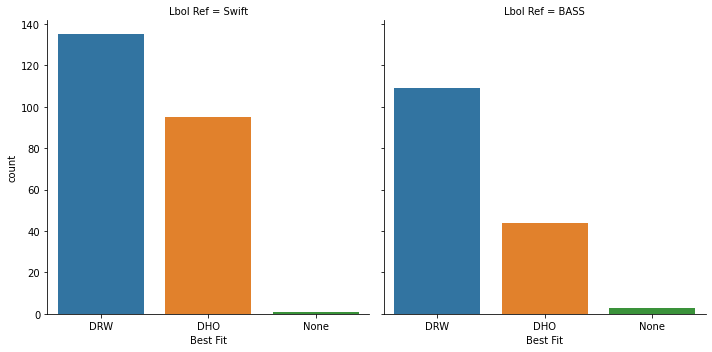

In [14]:
# Draw a nested barplot by species and sex
sns.catplot(data=agn_dataframe,
            x='Best Fit', col='Lbol Ref', kind='count')

## Appendix:

In [3]:
flag = [float('inf')]

# Converts a string into a float list.
# String must be in the following format:
# '[1.01, 2.02, 3.03, 4.04]'
# Returns an array of len=1 with the one index='inf' if the String
# cannont be converted into a list of floats.
# Takes an optional string char for the characters to split by
def convert_to_float_list(str_list, **kwargs):
    char = kwargs.get('char', None)
    debug = kwargs.get('debug', False)
    
    if debug:
        print(str_list + ' foo')
        
    str_list = str_list.replace('[', '')
    str_list = str_list.replace(']', '')
    
    if debug:
        print(str_list + ' bar')
    
    try:
        return [float(i) for i in str_list.split(char)]
    except ValueError:
        return flag